In [2]:
!pip install livelossplot

In [3]:
from skimage.transform import resize, rescale
import skimage.io as skio

from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import os
import glob

from tqdm.notebook import tqdm as tqdm
from livelossplot import PlotLosses

import xml.etree.ElementTree as ET 

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision.transforms import *

import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim


## Data Loading

In [5]:
%%capture
if not os.path.exists('/ibug_300W_large_face_landmark_dataset'):
    !wget https://people.eecs.berkeley.edu/~zhecao/ibug_300W_large_face_landmark_dataset.zip
    !unzip 'ibug_300W_large_face_landmark_dataset.zip'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.zip'

In [6]:
os.listdir('ibug_300W_large_face_landmark_dataset')

['ibug', 'labels_ibug_300W_train.xml', 'afw', 'lfpw', 'helen']

In [7]:
class LargeFaceDataset(Dataset):
    def __init__(self, img_transform=None, keypoint_transform=None, total_imgs=32):
        tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root = tree.getroot()
        root_dir = 'ibug_300W_large_face_landmark_dataset'
        self.root_dir = 'ibug_300W_large_face_landmark_dataset'
        
        bboxes = [] # face bounding box used to crop the image
        landmarks = [] # the facial keypoints/landmarks for the whole training dataset
        img_filenames = [] # the image names for the whole dataset

        for filename in tqdm(root[2][:total_imgs]):
            img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
            box = filename[0].attrib
            # x, y for the top left corner of the box, w, h for box width and height
            bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            landmarks.append(landmark)
        
        self.landmarks = np.array(landmarks).astype('float32')     
        self.bboxes = np.array(bboxes).astype('float32')
        self.img_filenames = img_filenames 

        self.img_transform = img_transform
        self.keypoint_transform = keypoint_transform
    
    def __len__(self):
        return len(self.img_filenames)
    
    def __getitem__(self, idx):
        img_path = self.img_filenames[idx]
        points = self.landmarks[idx]
        bbox = self.bboxes[idx]

        img = skio.imread(img_path, as_gray=True)
        img = np.float64(img)
        height = img.shape[0]
        width = img.shape[1]

        top = int(abs(bbox[1]))
        new_h = max(int(bbox[3]) + 40, int(bbox[2]) + 40, 224)
        left = int(abs(bbox[0]))
        img = img[top: top + new_h, left: left + new_h]

        # offset for crop
        points = points - [left, top]

        # renormalize points to new width and height
        points[:, 0] = points[:, 0] / new_h
        points[:, 1] = points[:, 1] / new_h

        sample = {'x': img, 'y': points}
        
        if self.keypoint_transform:
            sample = self.keypoint_transform(sample)
        
        if self.img_transform:
            img = self.img_transform(img)
   
        return {'x': img, 'y': sample['y']}


In [8]:
batch_size = 32
validation_split = 0.2
height = 224
width = 224
channels = 1

img_transforms = Compose([
            ToTensor(),
            Normalize(mean=[0.485],
                      std=[0.229]),
            Resize((height, width)),
            ColorJitter(),
        ])

keypoint_transforms = None

dataset = LargeFaceDataset(img_transform=img_transforms, keypoint_transform=keypoint_transforms)

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler) 

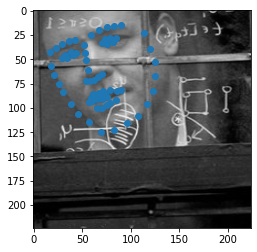

In [9]:
for i, sample in enumerate(train_loader):
    if i > 5:
      break
    img = sample['x'][0]
    points = sample['y'][0]
    plt.imshow(img.squeeze(), cmap='gray')
    plt.scatter(points[:, 0] * img.shape[2], points[:, 1] * img.shape[1])
    plt.show()

In [10]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        
        self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet18.fc = nn.Linear(512, 68*2)

    def forward(self, x):

        x = self.resnet18(x)
        return x



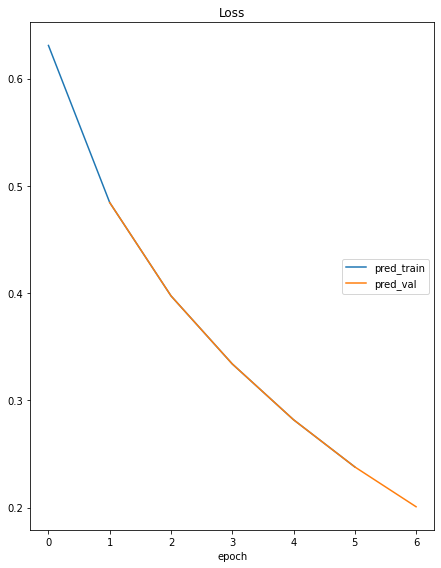

Loss
	pred_train       	 (min:    0.238, max:    0.631, cur:    0.238)
	pred_val         	 (min:    0.201, max:    0.484, cur:    0.201)


In [ ]:
#Hyperparameters 
epochs = 10
lr = 1e-4

# Loss
criterion = nn.MSELoss()

# Create Plots
plt_groups = {'loss':[]}
plotlosses_model = PlotLosses(groups=plt_groups)
plt_groups['loss'].append('pred_train')
plt_groups['loss'].append('pred_val')

# Training Loop
device = torch.device("cpu")

if torch.cuda.is_available():
    print(f"Training on GPU")
    device = torch.device("cuda")

# Model
net = ResNet().double()
net = net.to(device)


# Optimizer
optimizer = optim.Adam(net.parameters(), lr=lr)


iters = 0
for e in range(epochs):
    for batch_i, sample_batch in tqdm(enumerate(train_loader), leave=False, desc='iter', total=len(dataset) // batch_size):
        optimizer.zero_grad()   # zero the gradient buffers

        images = sample_batch['x'].to(device)
        points = sample_batch['y']
        points = np.reshape(points, (points.shape[0], -1))
        target = points.to(device)

        output = net(images)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        plotlosses_model.update({'pred_train':loss.item()}, current_step=iters)
        iters += 1
    
    # get validation loss
    val_values = []
    for batch_i, sample_valid_batch in tqdm(enumerate(validation_loader), leave=False, desc='iter'):
        with torch.no_grad():
            images = sample_batch['x'].to(device)
            points = sample_batch['y']
            points = np.reshape(points, (points.shape[0], -1))
            target = points.to(device)
            
            output = net(images)            
            loss = criterion(output, target)

            val_values.append(loss.item())

    torch.save({
            'epoch': e,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': np.mean(val_values)
            }, f'checkpoint_{e}')

        
    plotlosses_model.update({'pred_val':np.mean(val_values)}, current_step=iters)
    plotlosses_model.send()

In [ ]:
train_loss = [float(x[1]) for x in plotlosses_model.logger.log_history['pred_train']]
val_loss = [float(x[1]) for x in plotlosses_model.logger.log_"history['pred_val']]
plt.plot(range(len(train_loss)), train_loss)
plt.plot(range(0, len(train_loss), len(train_loss)//len(val_loss)), val_loss)
plt.ylim(0, 1)
plt.show()

In [2]:
with torch.no_grad():
  for batch_i, sample_valid_batch in tqdm(enumerate(validation_loader), leave=False, desc='iter'):
      if batch_i > 3:
          break
      val_imgs = sample_valid_batch['x']
      val_points = sample_valid_batch['y']
      
      pred = net(val_imgs)
      pred = pred.reshape(val_points.shape)
      
      plt.imshow(val_imgs[0].squeeze(), cmap='gray')
      plt.scatter(val_points[0, :, 0] * width, val_points[0, :, 1] * height)
      plt.scatter(pred[0, :, 0] * width, pred[0, :, 1] * height)
      plt.show()

NameError: ignored

In [ ]:
for batch_i, sample_valid_batch in tqdm(enumerate(train_loader), leave=False, desc='iter'):
    if batch_i > 3:
        break
    val_imgs = sample_valid_batch['x'].numpy()
    val_points = sample_valid_batch['y'].numpy()
    pred = model(save_params, val_imgs)
    pred = pred.reshape(val_points.shape)
    plt.imshow(val_imgs[0] + 0.5, cmap='gray')
    plt.scatter(val_points[0, :, 0] * width, val_points[0, :, 1] * height)
    plt.scatter(pred[0, :, 0] * width, pred[0, :, 1] * height)
    plt.show()
    print(np.mean((val_points - pred)**2))

In [ ]:
plotlosses_model.send()